In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import duckdb

In [3]:
con = duckdb.connect("/content/drive/MyDrive/MFM project/bankruptcy_data.db")

In [4]:
con.execute("SHOW TABLES").df().tail(10)

,name
401,ZTNO
402,ZVOI
403,bankrupted
404,bankrupted_prob_results
405,financial2
406,financial3
407,financial4
408,financials
409,non_bankrupted
410,non_bankrupted_prob_results


In [5]:
bankrupted = con.execute("SELECT * FROM bankrupted ").fetchdf().drop(columns = ['Date', 'Available']) # drop extra column to concat
bankrupted.columns = ['ticker', 'company', 'enddate', 'start_date']
non_bankrupted = con.execute("SELECT * FROM non_bankrupted ").fetchdf().drop(columns=['ticker']) # drop extra column to concat
non_bankrupted.columns = ['ticker', 'company', 'enddate', 'start_date']
bankrupted_probs = con.execute("SELECT * FROM bankrupted_prob_results ").fetchdf()
non_bankrupted_probs = con.execute("SELECT * FROM non_bankrupted_prob_results ").fetchdf()

In [6]:
bankrupted['bankrupted'] = 1
non_bankrupted['bankrupted'] = 0

In [7]:
bankrupted_data = pd.concat([bankrupted, non_bankrupted])
bankrupted_data.head()

,ticker,company,enddate,start_date,bankrupted
0,VELTF,Velti PLC,2015-12-24,2011-12-24,1
1,NOEC,New Oriental Energy & Chemical Corp,2015-12-24,2011-12-24,1
2,CRMBQ,Crumbs Bake Shop Inc,2015-12-24,2011-12-24,1
3,INOW,Infonow Corp,2015-12-18,2011-12-18,1
4,VALV,Shengkai Innovations Inc,2015-12-11,2011-12-11,1


In [8]:
bankrupted_probs.head()

,ticker,quarter_end,kmv_prob_default,zpp_prob_default
0,RNVA,2015-12-31,0.000000e+00,0.94368
1,RNVA,2015-12-31,1.000000e+00,0.94282
2,RNVA,2015-12-31,0.000000e+00,0.94212
3,RNVA,2016-03-31,1.000000e+00,0.95122
4,RNVA,2016-06-30,8.346134e-42,0.42170


In [9]:
bankrupted_probs.ticker.nunique()

51

In [10]:
non_bankrupted_probs.head()

,ticker,quarter_end,kmv_prob_default,zpp_prob_default
0,CRSP,2018-03-31,0.000000e+00,0.03058
1,CRSP,2018-06-30,2.298315e-04,0.03116
2,CRSP,2018-09-30,7.474074e-08,0.73244
3,CRSP,2018-12-31,2.990852e-07,0.62270
4,CRSP,2018-12-31,4.335628e-05,0.62516


In [11]:
non_bankrupted_probs.ticker.nunique()

69

In [12]:
prob_data = pd.concat([bankrupted_probs, non_bankrupted_probs])
prob_data.head()

,ticker,quarter_end,kmv_prob_default,zpp_prob_default
0,RNVA,2015-12-31,0.000000e+00,0.94368
1,RNVA,2015-12-31,1.000000e+00,0.94282
2,RNVA,2015-12-31,0.000000e+00,0.94212
3,RNVA,2016-03-31,1.000000e+00,0.95122
4,RNVA,2016-06-30,8.346134e-42,0.42170


In [13]:
prob_and_bankrupt = prob_data.merge(bankrupted_data[['ticker', 'enddate', 'bankrupted']], on = 'ticker', how = 'left')
prob_and_bankrupt.head()

,ticker,quarter_end,kmv_prob_default,zpp_prob_default,enddate,bankrupted
0,RNVA,2015-12-31,0.000000e+00,0.94368,2018-09-14,1
1,RNVA,2015-12-31,1.000000e+00,0.94282,2018-09-14,1
2,RNVA,2015-12-31,0.000000e+00,0.94212,2018-09-14,1
3,RNVA,2016-03-31,1.000000e+00,0.95122,2018-09-14,1
4,RNVA,2016-06-30,8.346134e-42,0.42170,2018-09-14,1


In [14]:
prob_and_bankrupt['year_end_1yb4'] = pd.to_datetime(prob_and_bankrupt['enddate']) + pd.offsets.DateOffset(years = -1) + pd.offsets.YearEnd(n = 0)
prob_and_bankrupt.head()

,ticker,quarter_end,kmv_prob_default,zpp_prob_default,enddate,bankrupted,year_end_1yb4
0,RNVA,2015-12-31,0.000000e+00,0.94368,2018-09-14,1,2017-12-31
1,RNVA,2015-12-31,1.000000e+00,0.94282,2018-09-14,1,2017-12-31
2,RNVA,2015-12-31,0.000000e+00,0.94212,2018-09-14,1,2017-12-31
3,RNVA,2016-03-31,1.000000e+00,0.95122,2018-09-14,1,2017-12-31
4,RNVA,2016-06-30,8.346134e-42,0.42170,2018-09-14,1,2017-12-31


In [15]:
## clean up month in quarterend
prob_and_bankrupt['months'] = pd.to_datetime(prob_and_bankrupt['quarter_end']).dt.month
prob_and_bankrupt.months.value_counts()

,count
months,
12,1017
9,860
6,803
3,771


In [16]:
prob_and_bankrupt.shape

(3451, 8)

In [17]:
prob_and_bankrupt = prob_and_bankrupt[
    ((prob_and_bankrupt.quarter_end <= prob_and_bankrupt.year_end_1yb4) & prob_and_bankrupt.bankrupted == 1) |
    (prob_and_bankrupt.bankrupted == 0)
]

In [18]:
prob_and_bankrupt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3451 entries, 0 to 3450
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ticker            3451 non-null   object        
 1   quarter_end       3451 non-null   datetime64[us]
 2   kmv_prob_default  3397 non-null   float32       
 3   zpp_prob_default  3451 non-null   float32       
 4   enddate           3451 non-null   datetime64[us]
 5   bankrupted        3451 non-null   int64         
 6   year_end_1yb4     3451 non-null   datetime64[us]
 7   months            3451 non-null   int32         
dtypes: datetime64[us](3), float32(2), int32(1), int64(1), object(1)
memory usage: 175.4+ KB


In [19]:
prob_and_bankrupt.drop_duplicates(['ticker', 'quarter_end'], keep='last', inplace = True)

In [20]:
prob_and_bankrupt.shape

(1980, 8)

In [21]:
prob_and_bankrupt.head()

,ticker,quarter_end,kmv_prob_default,zpp_prob_default,enddate,bankrupted,year_end_1yb4,months
2,RNVA,2015-12-31,0.000000e+00,0.94212,2018-09-14,1,2017-12-31,12
3,RNVA,2016-03-31,1.000000e+00,0.95122,2018-09-14,1,2017-12-31,3
4,RNVA,2016-06-30,8.346134e-42,0.42170,2018-09-14,1,2017-12-31,6
5,RNVA,2016-09-30,0.000000e+00,0.97970,2018-09-14,1,2017-12-31,9
7,RNVA,2016-12-31,0.000000e+00,0.88128,2018-09-14,1,2017-12-31,12


In [22]:
arranged_prob_and_bankrupted_kmv = pd.DataFrame()
arranged_prob_and_bankrupted_zpp = pd.DataFrame()
for ticker in prob_and_bankrupt.ticker.unique():
    quarter_index = []
    temp = prob_and_bankrupt[prob_and_bankrupt.ticker == ticker].sort_values(by = 'quarter_end', ascending = False)
    for i, quarter in enumerate(temp.quarter_end):
        quarter_index.append(i+1)
    temp['quarter_index'] = quarter_index
    kmv_pivot = temp.pivot(index = 'ticker', columns = 'quarter_index', values = 'kmv_prob_default').round(4)
    zpp_pivot = temp.pivot(index = 'ticker', columns = 'quarter_index', values = 'zpp_prob_default').round(4)
    arranged_prob_and_bankrupted_kmv = pd.concat([arranged_prob_and_bankrupted_kmv, kmv_pivot])
    arranged_prob_and_bankrupted_zpp = pd.concat([arranged_prob_and_bankrupted_zpp, zpp_pivot])

In [23]:
arranged_prob_and_bankrupted_kmv = arranged_prob_and_bankrupted_kmv.sort_index(axis = 1, ascending = False)

In [24]:
arranged_prob_and_bankrupted_kmv.columns = ["B4Q" + str(x) for x in arranged_prob_and_bankrupted_kmv.columns.tolist()]
arranged_prob_and_bankrupted_kmv.head()

,B4Q26,B4Q25,B4Q24,B4Q23,B4Q22,B4Q21,B4Q20,B4Q19,B4Q18,B4Q17,...,B4Q10,B4Q9,B4Q8,B4Q7,B4Q6,B4Q5,B4Q4,B4Q3,B4Q2,B4Q1
ticker,,,,,,,,,,,,,,,,,,,,,
RNVA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
GXXM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0095,0.0000,0.0040,0.6133,0.0024,0.9118
YUMAQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0004,0.0051,0.6908,0.0002,0.0088,0.8976,0.6143,0.6193,0.5713,0.8809
GLAE,NaN,NaN,NaN,NaN,NaN,0.0,0.0000,0.000,0.0,0.0,...,0.0231,0.5259,0.0000,0.2958,0.7304,0.0383,0.0261,0.6942,0.9650,0.6938
BMTM,NaN,NaN,NaN,NaN,NaN,NaN,0.0002,0.005,0.0,0.0,...,0.6692,0.7409,0.9936,0.0564,0.9189,0.6694,0.1970,0.3993,0.0488,0.8282


In [25]:
kmv_data = arranged_prob_and_bankrupted_kmv.dropna(axis = 1, thresh = 100).fillna(0).reset_index()

In [26]:
kmv_data

,ticker,B4Q11,B4Q10,B4Q9,B4Q8,B4Q7,B4Q6,B4Q5,B4Q4,B4Q3,B4Q2,B4Q1
0,RNVA,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,GXXM,0.0000,0.0000,0.0000,0.0000,0.0000,0.0095,0.0000,0.0040,0.6133,0.0024,0.9118
2,YUMAQ,0.1624,0.0004,0.0051,0.6908,0.0002,0.0088,0.8976,0.6143,0.6193,0.5713,0.8809
3,GLAE,0.0000,0.0231,0.5259,0.0000,0.2958,0.7304,0.0383,0.0261,0.6942,0.9650,0.6938
4,BMTM,0.3601,0.6692,0.7409,0.9936,0.0564,0.9189,0.6694,0.1970,0.3993,0.0488,0.8282
...,...,...,...,...,...,...,...,...,...,...,...,...
115,DXCM,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
116,DXC,0.6920,0.5015,0.1094,0.0522,0.0000,0.0000,0.0049,0.0000,0.0162,0.0282,0.0626
117,DGX,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
118,DG,0.5588,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0032


In [27]:
arranged_prob_and_bankrupted_zpp =  arranged_prob_and_bankrupted_zpp.sort_index(axis = 1, ascending = False)
arranged_prob_and_bankrupted_zpp.columns = ["B4Q" + str(x) for x in arranged_prob_and_bankrupted_zpp.columns.tolist()]
arranged_prob_and_bankrupted_zpp.reset_index(inplace = True)
zpp_data = arranged_prob_and_bankrupted_zpp[kmv_data.columns].fillna(0)

In [28]:
zpp_data

,ticker,B4Q11,B4Q10,B4Q9,B4Q8,B4Q7,B4Q6,B4Q5,B4Q4,B4Q3,B4Q2,B4Q1
0,RNVA,0.0000,0.0000,0.9421,0.9512,0.4217,0.9797,0.8813,0.8844,1.0000,0.9966,0.9761
1,GXXM,0.0000,0.0000,0.0000,0.0000,0.0000,0.7844,0.5833,0.6104,0.9581,0.7040,0.9752
2,YUMAQ,0.9436,1.0000,0.9993,0.0001,0.0000,0.9997,0.3683,1.0000,0.0000,0.8030,0.7131
3,GLAE,0.2493,0.7944,0.9976,0.6313,0.9622,0.8770,0.4174,0.8681,0.8235,0.1848,0.1354
4,BMTM,0.5205,0.1826,0.0045,0.8310,0.2792,0.0001,0.5574,0.9927,0.8548,0.5640,0.1970
...,...,...,...,...,...,...,...,...,...,...,...,...
115,DXCM,0.0233,0.0073,0.0354,0.0884,0.0091,0.9845,0.0212,0.0004,0.0002,0.6479,0.0002
116,DXC,0.0319,0.0802,0.0000,0.0105,0.0268,0.0050,0.0034,0.3007,0.3064,0.3434,0.0330
117,DGX,0.0005,0.0004,0.0054,0.0001,0.0000,0.0019,0.0000,0.0000,0.0000,0.0000,0.0707
118,DG,0.0003,0.0004,0.0000,0.0044,0.1070,0.0002,0.0000,0.0032,0.4924,0.9076,0.0187


In [29]:
kmv_data = kmv_data.merge(bankrupted_data[['ticker', 'bankrupted']], on = 'ticker', how = 'left')
zpp_data = zpp_data.merge(bankrupted_data[['ticker', 'bankrupted']], on = 'ticker', how = 'left')

In [30]:
kmv_data.tail()

,ticker,B4Q11,B4Q10,B4Q9,B4Q8,B4Q7,B4Q6,B4Q5,B4Q4,B4Q3,B4Q2,B4Q1,bankrupted
140,DXC,0.6920,0.5015,0.1094,0.0522,0.0,0.0000,0.0049,0.0,0.0162,0.0282,0.0626,0
141,DGX,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0
142,DG,0.5588,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0032,0
143,CVGW,0.4280,0.0000,0.0000,0.0000,0.0,0.0687,0.0000,0.0,0.0000,0.0000,0.0001,0
144,CVGW,0.4280,0.0000,0.0000,0.0000,0.0,0.0687,0.0000,0.0,0.0000,0.0000,0.0001,0


In [31]:
zpp_data.ticker.duplicated().sum(), kmv_data.ticker.duplicated().sum()

(np.int64(25), np.int64(25))

In [32]:
kmv_data = kmv_data.drop_duplicates(subset = 'ticker', keep = 'last')
zpp_data = zpp_data.drop_duplicates(subset = 'ticker', keep = 'last')

In [33]:
kmv_data.bankrupted.value_counts()

,count
bankrupted,
0,69
1,51


In [34]:
zpp_data.bankrupted.value_counts()

,count
bankrupted,
0,69
1,51


In [35]:
kmv_data.tail()

,ticker,B4Q11,B4Q10,B4Q9,B4Q8,B4Q7,B4Q6,B4Q5,B4Q4,B4Q3,B4Q2,B4Q1,bankrupted
139,DXCM,0.0001,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0
140,DXC,0.6920,0.5015,0.1094,0.0522,0.0,0.0000,0.0049,0.0,0.0162,0.0282,0.0626,0
141,DGX,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0
142,DG,0.5588,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0032,0
144,CVGW,0.4280,0.0000,0.0000,0.0000,0.0,0.0687,0.0000,0.0,0.0000,0.0000,0.0001,0


In [36]:
zpp_data.tail()

,ticker,B4Q11,B4Q10,B4Q9,B4Q8,B4Q7,B4Q6,B4Q5,B4Q4,B4Q3,B4Q2,B4Q1,bankrupted
139,DXCM,0.0233,0.0073,0.0354,0.0884,0.0091,0.9845,0.0212,0.0004,0.0002,0.6479,0.0002,0
140,DXC,0.0319,0.0802,0.0000,0.0105,0.0268,0.0050,0.0034,0.3007,0.3064,0.3434,0.0330,0
141,DGX,0.0005,0.0004,0.0054,0.0001,0.0000,0.0019,0.0000,0.0000,0.0000,0.0000,0.0707,0
142,DG,0.0003,0.0004,0.0000,0.0044,0.1070,0.0002,0.0000,0.0032,0.4924,0.9076,0.0187,0
144,CVGW,0.0000,0.0006,0.0062,0.0000,0.1559,0.8974,0.0000,0.2015,0.1603,0.5443,0.0456,0


In [37]:
set(kmv_data.ticker) - set(zpp_data.ticker)

set()

In [38]:
set(zpp_data.ticker) - set(kmv_data.ticker)

set()

In [177]:
import numpy as np
np.random.randint(100)

31

###K-FOLD CV

In [194]:
import matplotlib.pyplot as plt # Import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy import stats

def stability_analysis(df, data1_label, data2_label):
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    df1 = df[[v + '_' + data1_label.lower() for v in metrics]].std() / df[[v + '_' + data1_label.lower() for v in metrics]].mean()
    df2 = df[[v + '_' + data2_label.lower() for v in metrics]].std() / df[[v + '_' + data2_label.lower() for v in metrics]].mean()
    stability_df = pd.DataFrame({
        'Metrics': [v.title() for v in metrics],
        f'{data1_label}_Coefficient_Variation': df1.values.round(3).tolist(),
        f'{data2_label}_Coefficient_Variation': df2.values.round(3).tolist(),
        'Condition': np.where((df1.values - df2.values) >= 0, f'{data1_label} > {data2_label}', f'{data1_label} < {data2_label}'),
        'More_Stable': np.where(df1.values < df2.values, data1_label, data2_label)
    })
    return stability_df

def draw_compare_plot(df, data1_label, data2_label, year_before):
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    titles = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey = True, sharex=True)
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[i // 2][i % 2]

        sns.kdeplot(df[metric + '_' + data1_label.lower()], ax=ax, label=data1_label, fill=True, color='blue', alpha=0.3, bw_adjust=1.5)
        sns.kdeplot(df[metric + '_' + data2_label.lower()], ax=ax, label=data2_label, fill=True, color='red', alpha=0.3, bw_adjust=1.5)

        # CI for means
        mean1 = df[metric + '_' + data1_label.lower()].mean()
        mean2 = df[metric+ '_' + data2_label.lower()].mean()

        # T-test
        t_stat, p_value = stats.ttest_ind(df[metric + '_' + data1_label.lower()], df[metric+ '_' + data2_label.lower()])
        significance = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'

        ax.axvline(mean1, color='blue', linestyle='--', label=f'{data1_label} Mean: {mean1:.3f}')
        ax.axvline(mean2, color='red', linestyle='--', label=f'{data2_label} Mean: {mean2:.3f}')

        ax.set_title(f'{title} (t-test: p={p_value:.2e}, {significance})')
        ax.set_xlabel('')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.suptitle(f'Predicting {year_before} year before')
    plt.tight_layout()
    plt.show()

def nk_fold_lda_simulation(data1, data2, repetition, fold, data1_label, data2_label, year_before):
    """
    repetition: K
    fold: fold
    """

    print(f"Using {repetition}x{fold} K-fold Cross Validation for Metric Stability.")
    print('-'*50)
    year_before_col_map = {
        1: -1,
        2: -5,
        3: -9
    }

    accuracy_scores1 = []
    precision_scores1 = []
    recall_scores1 = []
    f1_scores1 = []

    accuracy_scores2 = []
    precision_scores2 = []
    recall_scores2 = []
    f1_scores2 = []

    scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

    # kmv part
    for i in range(repetition):

        X1 = data1.iloc[:, 1:year_before_col_map[year_before]]
        y1 = data1["bankrupted"]

        kf1 = KFold(n_splits=fold, shuffle=True, random_state=np.random.randint(100))

        lda1 = LinearDiscriminantAnalysis()

        # Perform cross validation
        cv_results1 = cross_validate(lda1, X1, y1, cv=kf1, scoring=scoring, return_train_score=False)
        accuracy_scores1.extend(cv_results1['test_accuracy'].tolist())
        precision_scores1.extend(cv_results1['test_precision_macro'].tolist())
        recall_scores1.extend(cv_results1['test_recall_macro'].tolist())
        f1_scores1.extend(cv_results1['test_f1_macro'].tolist())
    print(f'Feature columns for {data1_label}: ', X1.columns.tolist())

    # zpp part
    for i in range(repetition):

        X2 = data2.iloc[:, 1:year_before_col_map[year_before]]
        y2 = data2["bankrupted"]

        kf2 = KFold(n_splits=fold, shuffle=True, random_state=np.random.randint(100))

        lda2 = LinearDiscriminantAnalysis()

        # Perform cross validation
        cv_results2 = cross_validate(lda2, X2, y2, cv=kf2, scoring=scoring, return_train_score=False)
        accuracy_scores2.extend(cv_results2['test_accuracy'].tolist())
        precision_scores2.extend(cv_results2['test_precision_macro'].tolist())
        recall_scores2.extend(cv_results2['test_recall_macro'].tolist())
        f1_scores2.extend(cv_results2['test_f1_macro'].tolist())
    print(f'Feature columns for {data2_label}: ', X2.columns.tolist())

    result = pd.DataFrame()
    result['accuracy_'+data1_label.lower()] = accuracy_scores1
    result['precision_'+data1_label.lower()] = precision_scores1
    result['recall_'+data1_label.lower()] = recall_scores1
    result['f1_'+data1_label.lower()] = f1_scores1
    result['accuracy_'+data2_label.lower()] = accuracy_scores2
    result['precision_'+data2_label.lower()] = precision_scores2
    result['recall_'+data2_label.lower()] = recall_scores2
    result['f1_'+data2_label.lower()] = f1_scores2

    print(f"Assessing stability on datapoints: ", result.shape[0])
    print('\n')
    draw_compare_plot(result, data1_label, data2_label, year_before)
    print('\nStability Comparison: ')
    print('-'*20)
    print(stability_analysis(result, data1_label, data2_label).to_markdown())

### Paramters

In [195]:
repetition = 20
fold = 5

### 1 year before

Using 20x5 K-fold Cross Validation for Metric Stability.
--------------------------------------------------
Feature columns for KMV:  ['B4Q11', 'B4Q10', 'B4Q9', 'B4Q8', 'B4Q7', 'B4Q6', 'B4Q5', 'B4Q4', 'B4Q3', 'B4Q2', 'B4Q1']
Feature columns for ZPP:  ['B4Q11', 'B4Q10', 'B4Q9', 'B4Q8', 'B4Q7', 'B4Q6', 'B4Q5', 'B4Q4', 'B4Q3', 'B4Q2', 'B4Q1']
Assessing stability on datapoints:  100




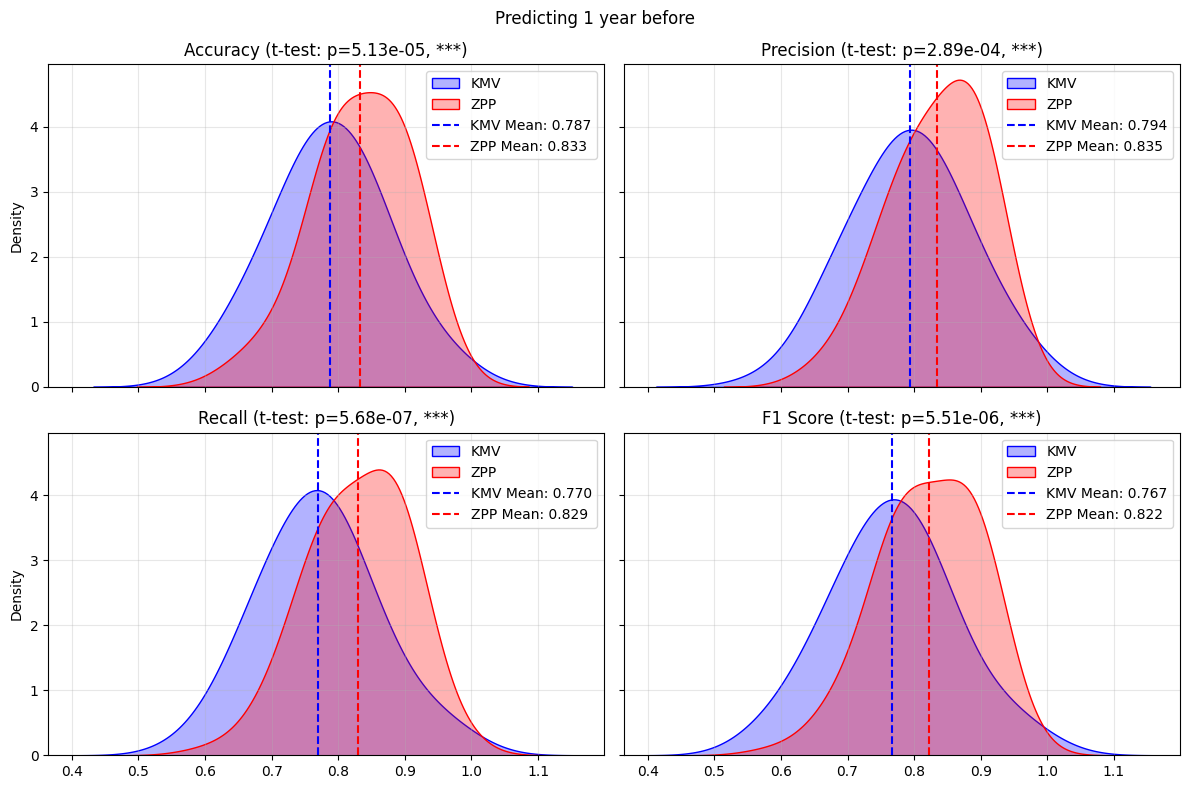


Stability Comparison: 
--------------------
|    | Metrics   |   KMV_Coefficient_Variation |   ZPP_Coefficient_Variation | Condition   | More_Stable   |
|---:|:----------|----------------------------:|----------------------------:|:------------|:--------------|
|  0 | Accuracy  |                       0.107 |                       0.086 | KMV > ZPP   | ZPP           |
|  1 | Precision |                       0.109 |                       0.084 | KMV > ZPP   | ZPP           |
|  2 | Recall    |                       0.113 |                       0.089 | KMV > ZPP   | ZPP           |
|  3 | F1        |                       0.117 |                       0.09  | KMV > ZPP   | ZPP           |


In [196]:
nk_fold_lda_simulation(kmv_data.copy(), zpp_data.copy(), repetition, fold, 'KMV', 'ZPP', 1)

### 2 year before

Using 20x5 K-fold Cross Validation for Metric Stability.
--------------------------------------------------
Feature columns for KMV:  ['B4Q11', 'B4Q10', 'B4Q9', 'B4Q8', 'B4Q7', 'B4Q6', 'B4Q5']
Feature columns for ZPP:  ['B4Q11', 'B4Q10', 'B4Q9', 'B4Q8', 'B4Q7', 'B4Q6', 'B4Q5']
Assessing stability on datapoints:  100




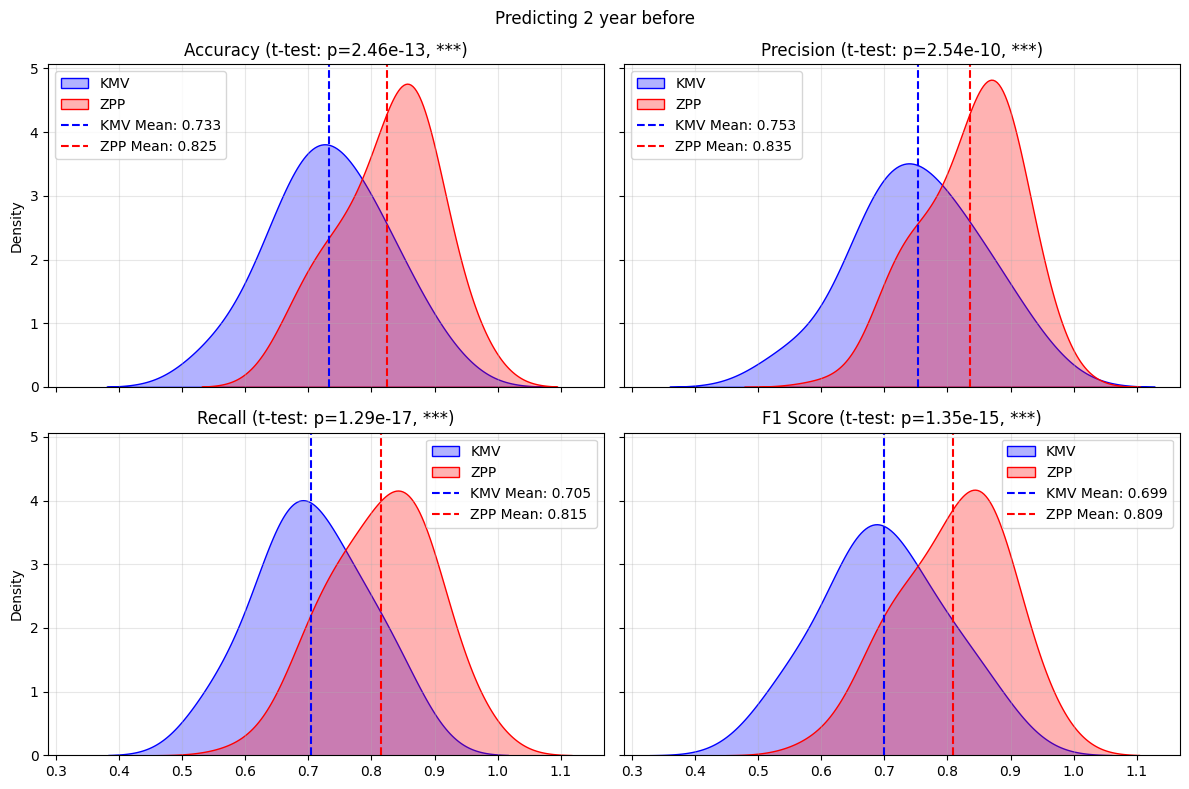


Stability Comparison: 
--------------------
|    | Metrics   |   KMV_Coefficient_Variation |   ZPP_Coefficient_Variation | Condition   | More_Stable   |
|---:|:----------|----------------------------:|----------------------------:|:------------|:--------------|
|  0 | Accuracy  |                       0.123 |                       0.092 | KMV > ZPP   | ZPP           |
|  1 | Precision |                       0.131 |                       0.089 | KMV > ZPP   | ZPP           |
|  2 | Recall    |                       0.121 |                       0.099 | KMV > ZPP   | ZPP           |
|  3 | F1        |                       0.137 |                       0.102 | KMV > ZPP   | ZPP           |


In [197]:
nk_fold_lda_simulation(kmv_data.copy(), zpp_data.copy(), repetition, fold, 'KMV', 'ZPP', 2)

### 3 year before

Using 20x5 K-fold Cross Validation for Metric Stability.
--------------------------------------------------
Feature columns for KMV:  ['B4Q11', 'B4Q10', 'B4Q9']
Feature columns for ZPP:  ['B4Q11', 'B4Q10', 'B4Q9']
Assessing stability on datapoints:  100




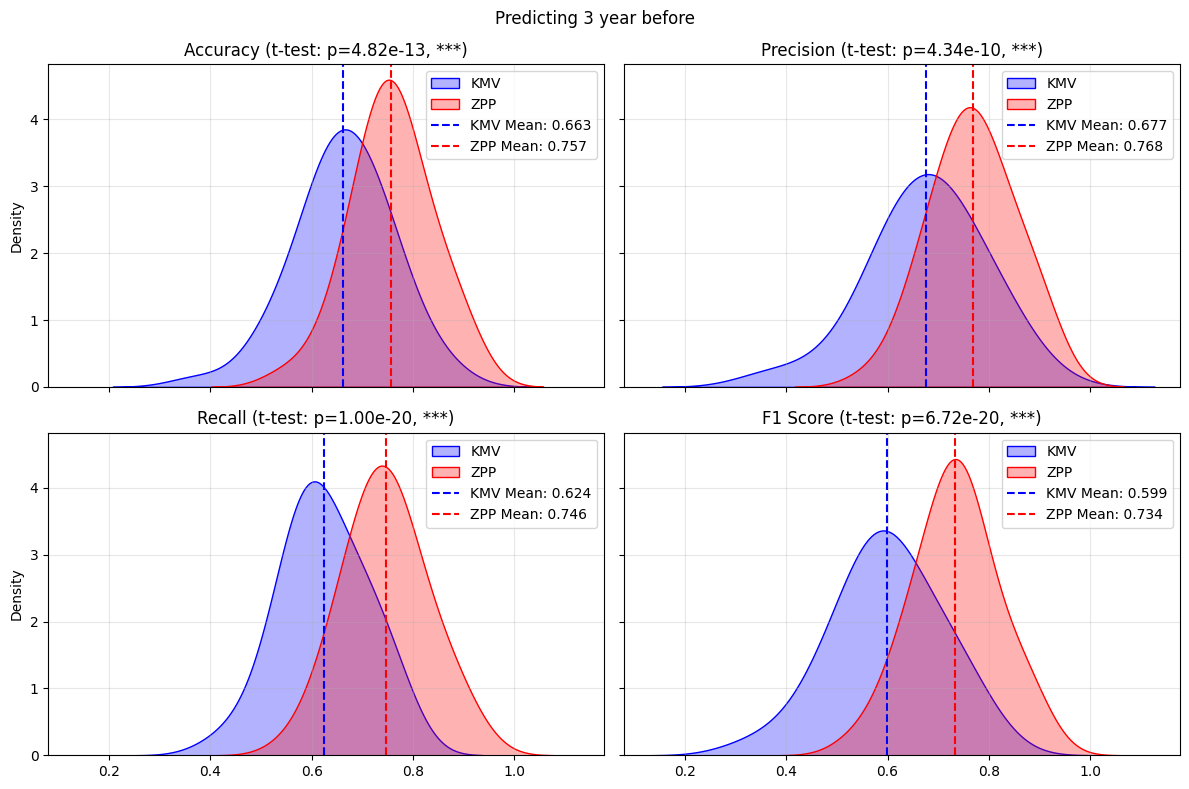


Stability Comparison: 
--------------------
|    | Metrics   |   KMV_Coefficient_Variation |   ZPP_Coefficient_Variation | Condition   | More_Stable   |
|---:|:----------|----------------------------:|----------------------------:|:------------|:--------------|
|  0 | Accuracy  |                       0.142 |                       0.104 | KMV > ZPP   | ZPP           |
|  1 | Precision |                       0.167 |                       0.106 | KMV > ZPP   | ZPP           |
|  2 | Recall    |                       0.135 |                       0.108 | KMV > ZPP   | ZPP           |
|  3 | F1        |                       0.175 |                       0.111 | KMV > ZPP   | ZPP           |


In [198]:
nk_fold_lda_simulation(kmv_data.copy(), zpp_data.copy(), repetition, fold, 'KMV', 'ZPP', 3)